In [1]:
!pip install --upgrade pymc3
!pip install --upgrade mkl
!pip install --upgrade graphviz

     |████████████████████████████████| 1.9 MB 4.5 MB/s 
     |████████████████████████████████| 2.8 MB 10.9 MB/s 
     |████████████████████████████████| 1.5 MB 16.4 MB/s 
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668094 sha256=5a3c134bb075a25a35eedc31b4ee97dc730224b31cd1111e478149e62f2ec354
  Stored in directory: /Users/alexkotlar/Library/Caches/pip/wheels/26/68/6f/745330367ce7822fe0cd863712858151f5723a0a5e322cc144
Successfully built theano
  Attempting uninstall: theano
    Found existing installation: Theano 1.0.4
    Uninstalling Theano-1.0.4:
      Successfully uninstalled Theano-1.0.4
  Attempting uninstall: arviz
    Found existing installation: arviz 0.7.0
    Uninstalling arviz-0.7.0:
      Successfully uninstalled arviz-0.7.0
  Attempting uninstall: pymc3
    Found existing installation: pymc3 3.8
    Uninstalling pymc3-3.8:
      Successfully uninstalled pymc3-3.8


In [6]:
import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns
import warnings

from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt

In [7]:
az.style.use("arviz-darkgrid")
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(3264602)  # from random.org

In [8]:
N = 10000

μ_actual = np.array([1.0, -2.0])
sigmas_actual = np.array([0.7, 1.5])
Rho_actual = np.matrix([[1.0, -0.4], [-0.4, 1.0]])

Σ_actual = np.diag(sigmas_actual) * Rho_actual * np.diag(sigmas_actual)

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)
Σ_actual


matrix([[ 0.49, -0.42],
        [-0.42,  2.25]])

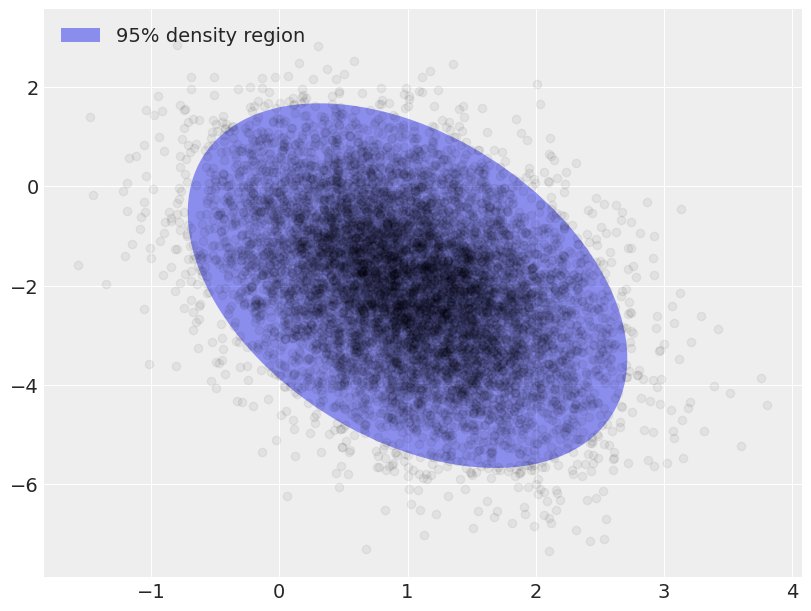

In [9]:
var, U = np.linalg.eig(Σ_actual)
angle = 180.0 / np.pi * np.arccos(np.abs(U[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red, *_ = sns.color_palette()

e = Ellipse(
    μ_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle
)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10)
ax.add_artist(e)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect], ["95% density region"], loc=2);

In [18]:
with pm.Model() as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))

In [19]:
packed_L.tag.test_value.shape

(3,)

In [20]:
with model:
    μ = pm.Normal("μ", 0.0, 1.5, shape=2, testval=x.mean(axis=0))
    obs = pm.MvNormal("obs", μ, chol=chol, observed=x)

In [21]:
with model:
    trace = pm.sample(random_seed=RANDOM_SEED, init="adapt_diag")
idata = az.from_pymc3(trace)
az.summary(idata, var_names=["~chol"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],1.02,0.01,1.00,1.03,0.0,0.0,5552.55,5550.49,5551.97,3250.90,1.0
μ[1],-2.03,0.01,-2.06,-2.00,0.0,0.0,5260.71,5257.99,5251.01,3664.33,1.0
chol_stds[0],0.69,0.00,0.68,0.70,0.0,0.0,5071.77,5071.77,5015.78,2988.14,1.0
chol_stds[1],1.50,0.01,1.48,1.52,0.0,0.0,6448.15,6447.96,6427.50,3443.19,1.0
"chol_corr[0,0]",1.00,0.00,1.00,1.00,0.0,0.0,4000.00,4000.00,4000.00,4000.00,NaN
"chol_corr[0,1]",-0.39,0.01,-0.41,-0.38,0.0,0.0,5015.76,5015.76,5023.34,3236.56,1.0
"chol_corr[1,0]",-0.39,0.01,-0.41,-0.38,0.0,0.0,5015.76,5015.76,5023.34,3236.56,1.0
"chol_corr[1,1]",1.00,0.00,1.00,1.00,0.0,0.0,4000.00,4000.00,3866.12,3718.48,1.0
"cov[0,0]",0.48,0.01,0.47,0.49,0.0,0.0,5074.43,5074.43,5015.78,2988.14,1.0
"cov[0,1]",-0.41,0.01,-0.43,-0.39,0.0,0.0,4712.92,4712.92,4711.40,3034.10,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa831b87a50>,
      dtype=object)

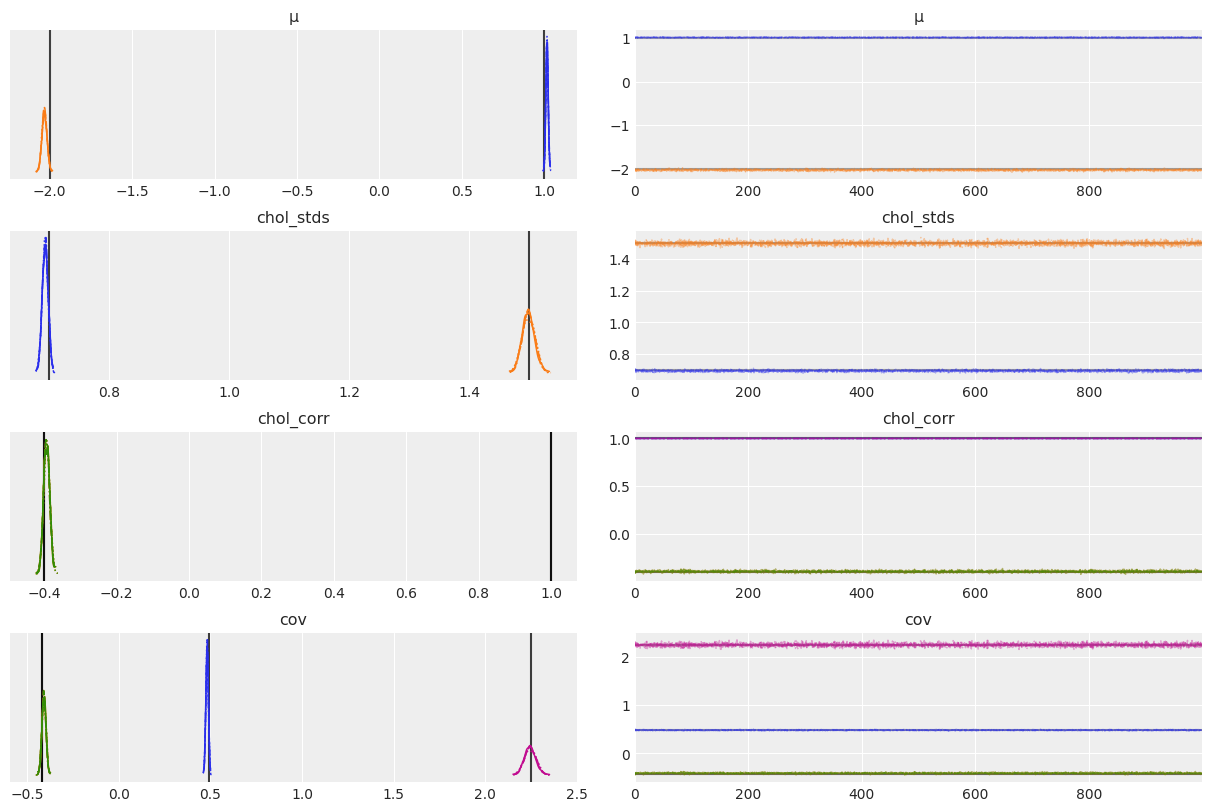

In [23]:
az.plot_trace(
    idata,
    var_names=["~chol"],
    compact=True,
    lines=[
        ("μ", {}, μ_actual),
        ("cov", {}, Σ_actual),
        ("chol_stds", {}, sigmas_actual),
        ("chol_corr", {}, Rho_actual),
    ],
)

In [24]:
μ_post = trace["μ"].mean(axis=0)
(1 - μ_post / μ_actual).round(2)

array([-0.02, -0.02])

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
122 0.16666666666666666


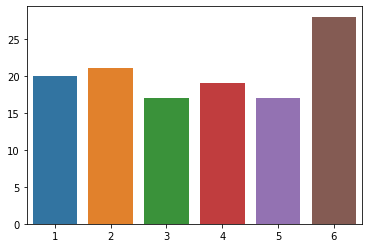

In [1]:
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

y = np.asarray([20,  21, 17, 19, 17, 28])
k = len(y)
p = 1/k
n = y.sum()
print(n, p)

sns.barplot(x=np.arange(1, k+1), y=y)

with pm.Model() as dice_model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a)
    
    # Since theta[5] will hold the posterior probability 
    # of rolling a 6 we'll compare this to the 
    # reference value p = 1/6 to determine the amount of bias
    # in the die 
    six_bias = pm.Deterministic("six_bias", theta[k-1] - p)
    
    results = pm.Multinomial("results", n=n, p=theta, observed=y)

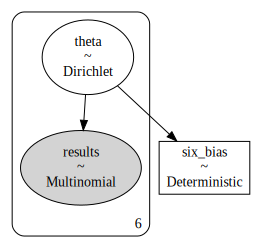

In [2]:
pm.model_to_graphviz(dice_model)

In [ ]:
with dice_model:
    dice_trace = pm.sample(draws=1000) 


In [ ]:
with dice_model:
    pm.traceplot(dice_trace, combined=True, lines={"theta": p})

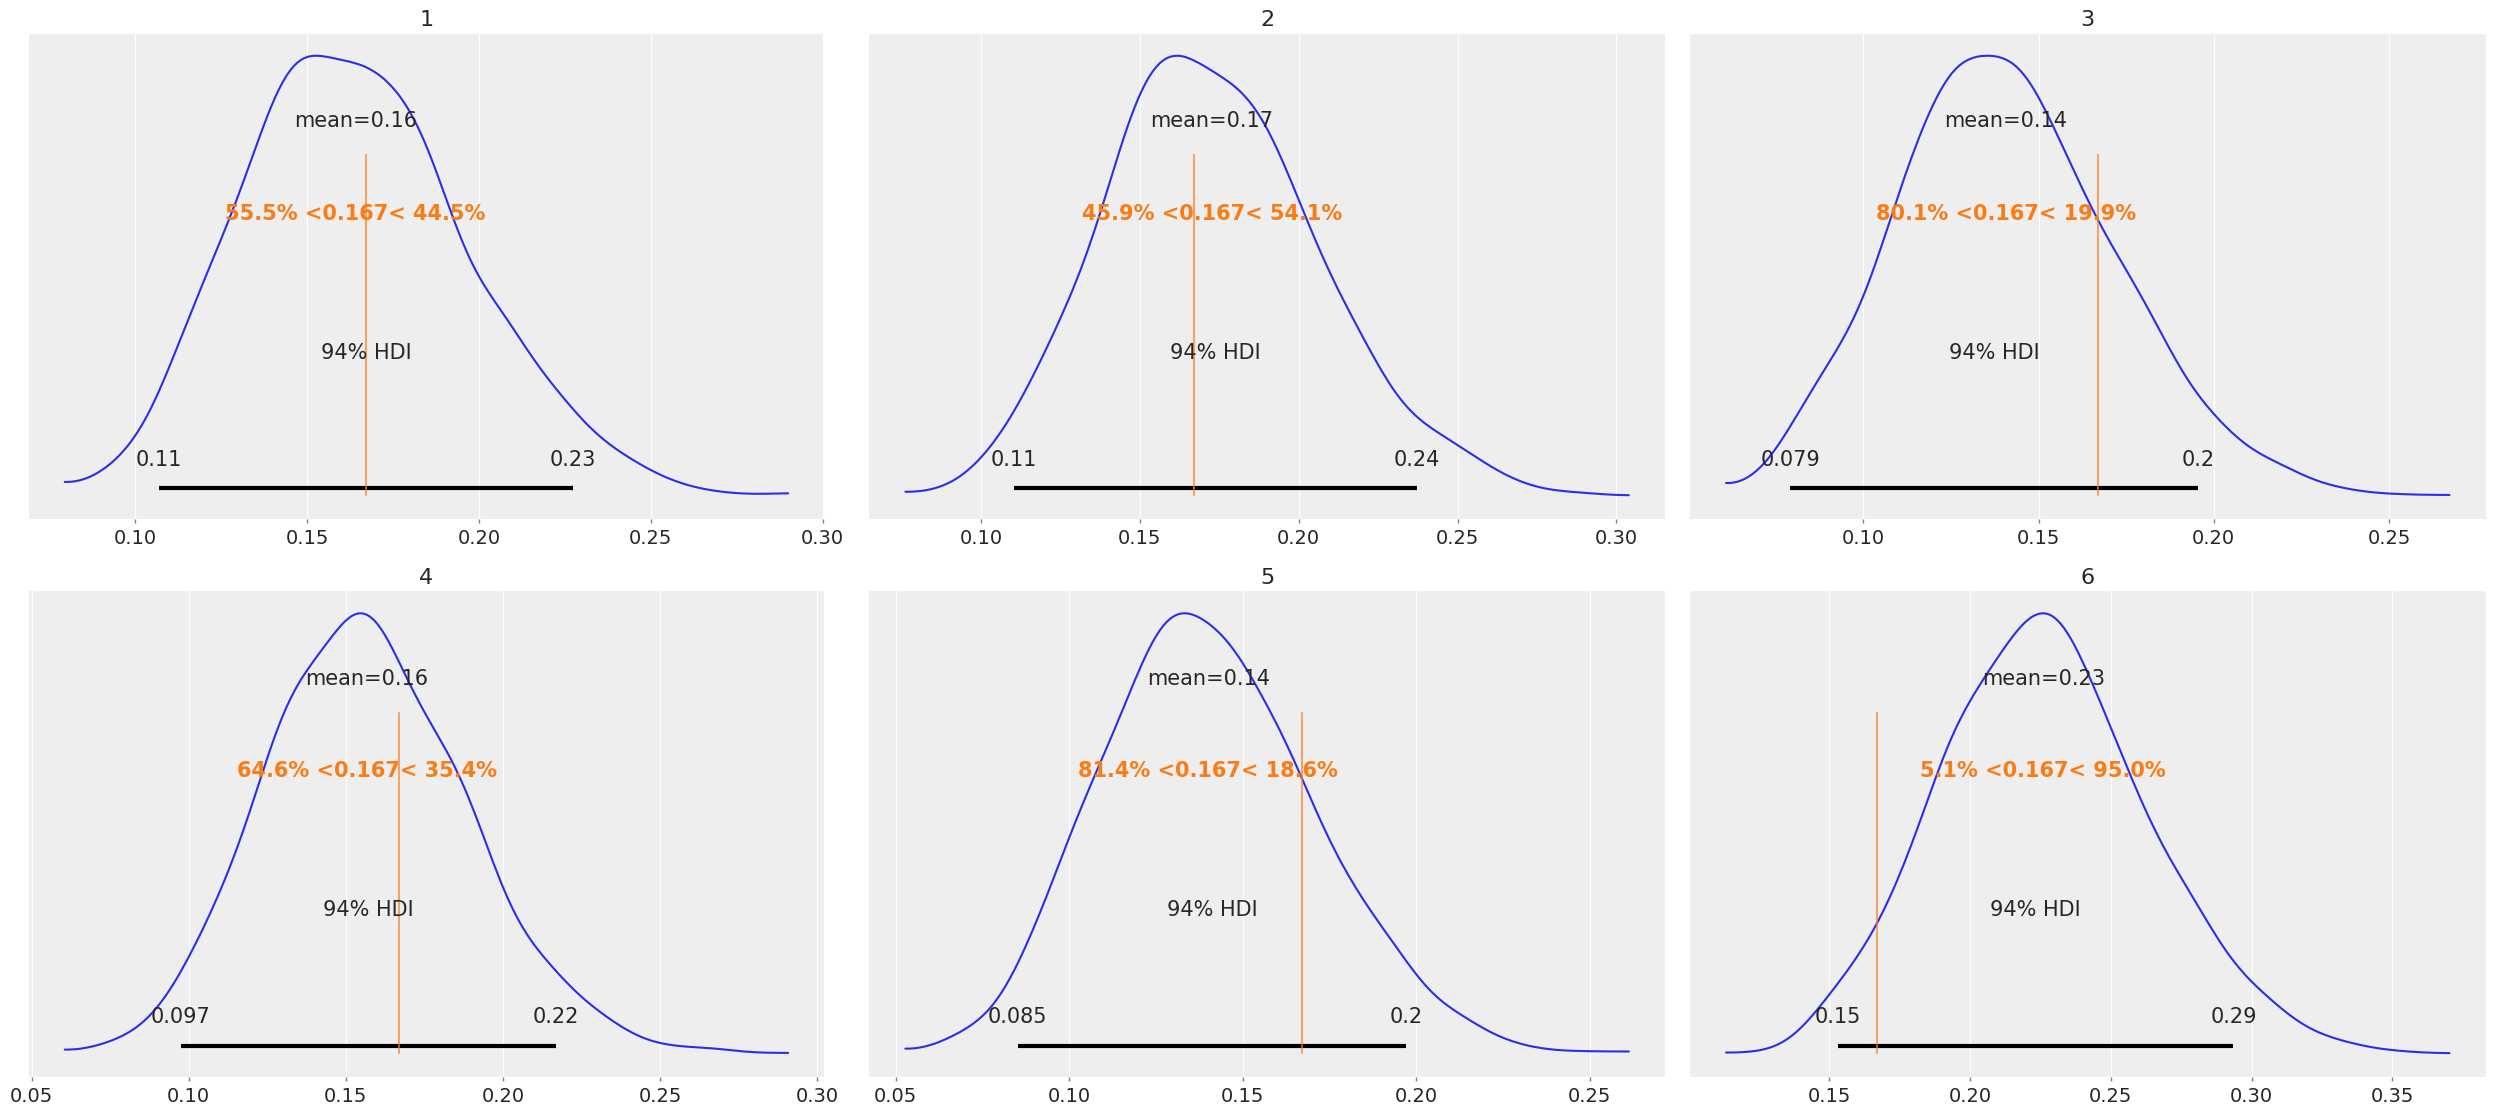

In [29]:
axes = pm.plot_posterior(dice_trace, 
                          varnames=["theta"], 
                          ref_val=np.round(p, 3))
for i, ax in enumerate(axes):
    ax.set_title(f"{i+1}")

In [4]:
y = np.asarray([727, 583, 137])
n = y.sum()
k = len(y)

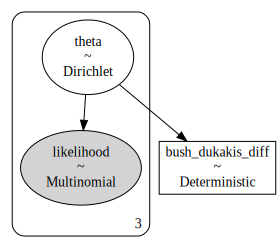

In [5]:
with pm.Model() as polling_model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a)
    
    bush_dukakis_diff = pm.Deterministic("bush_dukakis_diff",
                                          theta[0] - theta[1])
    
    likelihood = pm.Multinomial("likelihood", 
                                 n=n, 
                                 p=theta, 
                                 observed=y)
pm.model_to_graphviz(polling_model)

In [17]:
y2 = np.asarray([[727, 583, 137], [72337, 58, 13227]])
n2 = y.sum()
k2 = y2.shape[1]
a = np.stack([np.ones(k2), np.ones(k2)])
print(a)
a[0]

[[1. 1. 1.]
 [1. 1. 1.]]


array([1., 1., 1.])

In [25]:
pDs = np.array([.01, .01, .002])
pDs = np.array([1 - pDs.sum(), *pDs])
pDs

array([0.978, 0.01 , 0.01 , 0.002])

In [35]:
model = pm.Model()
K = 4 # number of genetic architectures #null, h1, h2, h12
pDs = np.array([[.01, .01, .002]]).T
# pDs = np.array([1 - pDs.sum(), *pDs])
with model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    alphas = [pm.Uniform(name=f"alpha_{i}", lower=1, upper=25000) for i in range(K)] #alph0, alpha1, alpha2, alpha12
    # a00 = pm.Deterministic("a00", alphas[0] * pDs[0])
    # a1s = pm.Deterministic("a1s", (alphas[1] + alphas[3]) * pDs[1])
    # a2s = pm.Deterministic("a2s", alphas[2] + alpahs[3])
    # a3s = pm.Deterministic("a2s", alphas[1] + alphas[2] + alpahs[3])
    component_alphas = np.array([
        [alphas[0], alphas[1], alphas[0], alphas[1]],
        [alphas[0], alphas[0], alphas[2], alphas[2]],
        [alphas[0], alphas[1] + alphas[3], alphas[2] + alphas[3], alphas[1] + alphas[2] + alphas[3]]
    ]) * pDs
    
    likelihood = pm.Multinomial("likelihood", 
                                 n=n, 
                                 p=component_alphas, 
                                 observed=y2)
pm.model_to_graphviz(polling_model)

ValueError: order must be one of 'C', 'F', 'A', or 'K' (got 'calphas')

In [9]:
np.stack([np.ones(k), np.ones(k)])

array([[1., 1.],
       [1., 1.]])

In [18]:
with polling_model:
    polling_trace = pm.sample(draws=10)

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
likelihood   -inf


ParallelSamplingError: Bad initial energy

In [20]:
for RV in polling_model.basic_RVs:
    print(RV.name, RV.logp(polling_model.test_point))

theta_stickbreaking__ -5.2053793708887675
likelihood -inf


In [23]:
from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
data = iris#pd.read_csv('iris.data', header=None, names=[0, 1, 2, 3, 'TYPE'])
print(data)
data['TYPE']= LabelEncoder().fit_transform(data['TYPE'])
y_obs = data['TYPE'].values
x_n = data.columns[:-1]
x = data[x_n].values
x = StandardScaler().fit_transform(x)
ndata = x.shape[0]
nparam = x.shape[1]
nclass = len(data['TYPE'].unique())

print( y_obs.shape, x.shape )


with pm.Model() as hazmat_model:
    X_data = pm.Data('X_data', x)
    y_obs_data = pm.Data('y_obs_data', y_obs)
    alfa = pm.Normal('alfa', mu=0, sd=1, shape=nclass)
    beta = pm.Normal('beta', mu=0, sd=1, shape=(nparam, nclass))
    mu = tt.dot(X_data, beta) + alfa
    p = tt.nnet.softmax(mu)
    yl = pm.Categorical('obs', p=p, observed=y_obs_data)
    trace = pm.sample()
    idata = az.from_pymc3(trace)
    pm.traceplot(idata)

with hazmat_model:
    pm.set_data({'X_data':np.random.normal(size=(8, 4))})
    pred = pm.fast_sample_posterior_predictive(trace)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

KeyError: 'TYPE'